# 라이브러리 불러오기

In [5]:
!pip install umap-learn

In [6]:
import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
import umap
from yellowbrick.text import UMAPVisualizer

In [7]:
# 한글폰트 사용을 위해 설치
# 아래 모듈을 설치하고 불러오면 별도의 한글폰트 설정이 필요 없습니다.
!pip install koreanize-matplotlib

import koreanize_matplotlib

# 1. 데이터 불러오기
- 데이터 불러오기
- 열 제거
    - 분석의 목표와 직접적인 관련이 없는 변수: 'PLAYER', 'W', 'L', 'TEAM', 'GP', 'TOTAL_MIN', 'SEASON', 'FP'
    - 다른 변수들로부터 파생되어 중복된 정보를 담거나 의미가 비슷한 변수: 'FG%', '3P%', 'FT%', 'REB'
        - 정보가 합쳐지기 이전의 변수들을 분석하는 게 선수 개인 성과를 분석하려는 본 분석의 목표에 더 적합할 것이라 판단
- 열 재나열
- 최대 행 출력 수 조정
- 통계량 확인

In [8]:
all_data=pd.read_csv('df_traditional.csv')
# 데이터 열들 str 변환 후 양옆 공백 제거
all_data.columns = all_data.columns.str.strip()
all_data = all_data[['TEAM_WITH_SEASON'] + [col for col in all_data.columns if col != 'TEAM_WITH_SEASON']]
all_data.head()

,TEAM_WITH_SEASON,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,...,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,SEASON,TOTAL_MIN
0,2000-01Allen Iverson,Allen Iverson,PHI,26,71,50,21,41.9,31.1,10.7,...,3.3,2.5,0.3,2.1,47.6,4.0,0.0,5.2,2000-01,2974.9
1,2000-01Jerry Stackhouse,Jerry Stackhouse,DET,26,80,31,49,40.1,29.8,9.7,...,4.1,1.2,0.7,2.0,43.8,5.0,1.0,-0.8,2000-01,3208.0
2,2000-01Shaquille O'Neal,Shaquille O'Neal,LAL,29,74,51,23,39.5,28.7,11.0,...,2.9,0.6,2.8,3.5,56.8,60.0,0.0,6.3,2000-01,2923.0
3,2000-01Kobe Bryant,Kobe Bryant,LAL,22,68,45,23,41.0,28.5,10.3,...,3.2,1.7,0.6,3.3,46.7,10.0,2.0,5.4,2000-01,2788.0
4,2000-01Vince Carter,Vince Carter,TOR,24,75,45,30,39.7,27.6,10.2,...,2.2,1.5,1.1,2.7,45.7,10.0,0.0,4.3,2000-01,2977.5


In [9]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TEAM_WITH_SEASON  7554 non-null   object 
 1   PLAYER            7554 non-null   object 
 2   TEAM              7554 non-null   object 
 3   AGE               7554 non-null   int64  
 4   GP                7554 non-null   int64  
 5   W                 7554 non-null   int64  
 6   L                 7554 non-null   int64  
 7   MIN               7554 non-null   float64
 8   PTS               7554 non-null   float64
 9   FGM               7554 non-null   float64
 10  FGA               7554 non-null   float64
 11  FG%               7554 non-null   float64
 12  3PM               7554 non-null   float64
 13  3PA               7554 non-null   float64
 14  3P%               7554 non-null   float64
 15  FTM               7554 non-null   float64
 16  FTA               7554 non-null   float64


In [10]:
all_data.drop(['PLAYER','W','L','TEAM','GP','TOTAL_MIN','SEASON','FG%','3P%','FT%','REB','FP'], axis=1, inplace=True)

# 최대 행 출력 수를 늘림
pd.set_option('display.max_columns', None)
all_data.head()

,TEAM_WITH_SEASON,AGE,MIN,PTS,FGM,FGA,3PM,3PA,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,PF,DD2,TD3,+/-
0,2000-01Allen Iverson,26,41.9,31.1,10.7,25.5,1.4,4.3,8.2,10.1,0.7,3.1,4.6,3.3,2.5,0.3,2.1,4.0,0.0,5.2
1,2000-01Jerry Stackhouse,26,40.1,29.8,9.7,24.1,2.1,5.9,8.3,10.1,1.2,2.7,5.1,4.1,1.2,0.7,2.0,5.0,1.0,-0.8
2,2000-01Shaquille O'Neal,29,39.5,28.7,11.0,19.2,0.0,0.0,6.7,13.1,3.9,8.8,3.7,2.9,0.6,2.8,3.5,60.0,0.0,6.3
3,2000-01Kobe Bryant,22,41.0,28.5,10.3,22.2,0.9,2.9,7.0,8.2,1.5,4.3,5.0,3.2,1.7,0.6,3.3,10.0,2.0,5.4
4,2000-01Vince Carter,24,39.7,27.6,10.2,22.1,2.2,5.3,5.1,6.7,2.3,3.2,3.9,2.2,1.5,1.1,2.7,10.0,0.0,4.3


In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TEAM_WITH_SEASON  7554 non-null   object 
 1   AGE               7554 non-null   int64  
 2   MIN               7554 non-null   float64
 3   PTS               7554 non-null   float64
 4   FGM               7554 non-null   float64
 5   FGA               7554 non-null   float64
 6   3PM               7554 non-null   float64
 7   3PA               7554 non-null   float64
 8   FTM               7554 non-null   float64
 9   FTA               7554 non-null   float64
 10  OREB              7554 non-null   float64
 11  DREB              7554 non-null   float64
 12  AST               7554 non-null   float64
 13  TOV               7554 non-null   float64
 14  STL               7554 non-null   float64
 15  BLK               7554 non-null   float64
 16  PF                7554 non-null   float64


In [12]:
all_data.describe()

,AGE,MIN,PTS,FGM,FGA,3PM,3PA,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,PF,DD2,TD3,+/-
count,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.00000,7554.000000,7554.000000,7554.000000,7554.000000
mean,27.091078,24.105083,10.208658,3.798107,8.325655,0.800503,2.232288,1.812126,2.378329,1.090455,3.171379,2.240575,1.372107,0.758353,0.48651,2.065766,6.060233,0.188642,0.049762
std,4.260661,8.265582,5.906969,2.121088,4.501944,0.784596,2.051433,1.472018,1.831249,0.834026,1.765030,1.890894,0.776223,0.413149,0.48934,0.660317,10.582290,1.320493,2.865354
min,18.000000,3.000000,0.500000,0.200000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.00000,0.200000,0.000000,0.000000,-9.600000
25%,24.000000,17.400000,5.700000,2.200000,4.800000,0.000000,0.200000,0.800000,1.100000,0.500000,1.900000,0.900000,0.800000,0.500000,0.20000,1.600000,0.000000,0.000000,-1.700000
50%,27.000000,24.100000,8.900000,3.300000,7.400000,0.700000,1.900000,1.400000,1.900000,0.800000,2.800000,1.600000,1.200000,0.700000,0.30000,2.050000,2.000000,0.000000,-0.200000
75%,30.000000,30.900000,13.500000,5.000000,11.000000,1.300000,3.600000,2.400000,3.100000,1.500000,4.000000,3.000000,1.800000,1.000000,0.60000,2.500000,7.000000,0.000000,1.700000
max,43.000000,43.700000,36.100000,12.200000,27.800000,5.300000,13.200000,10.200000,13.100000,5.400000,11.400000,11.700000,5.700000,2.900000,3.70000,4.300000,71.000000,42.000000,13.200000


In [13]:
all_data.nunique()

,0
TEAM_WITH_SEASON,7554
AGE,26
MIN,374
PTS,314
FGM,114
FGA,235
3PM,48
3PA,108
FTM,97
FTA,117


# 2. EDA
- 모든 변수들에 대해 시각화
    - 'PF', '+/-'를 제외한 모든 수치형 변수들에서 상당한 왜곡을 발견 -> 변수 변환 필요.
    - 'PF', '+/-'의 경우 약간의 왜도가 보이지만 이후 진행할 PCA/클러스터링이 정규성에 민감하지 않으므로 변수변환을 굳이 하지 않아도 될 것이라 판단.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

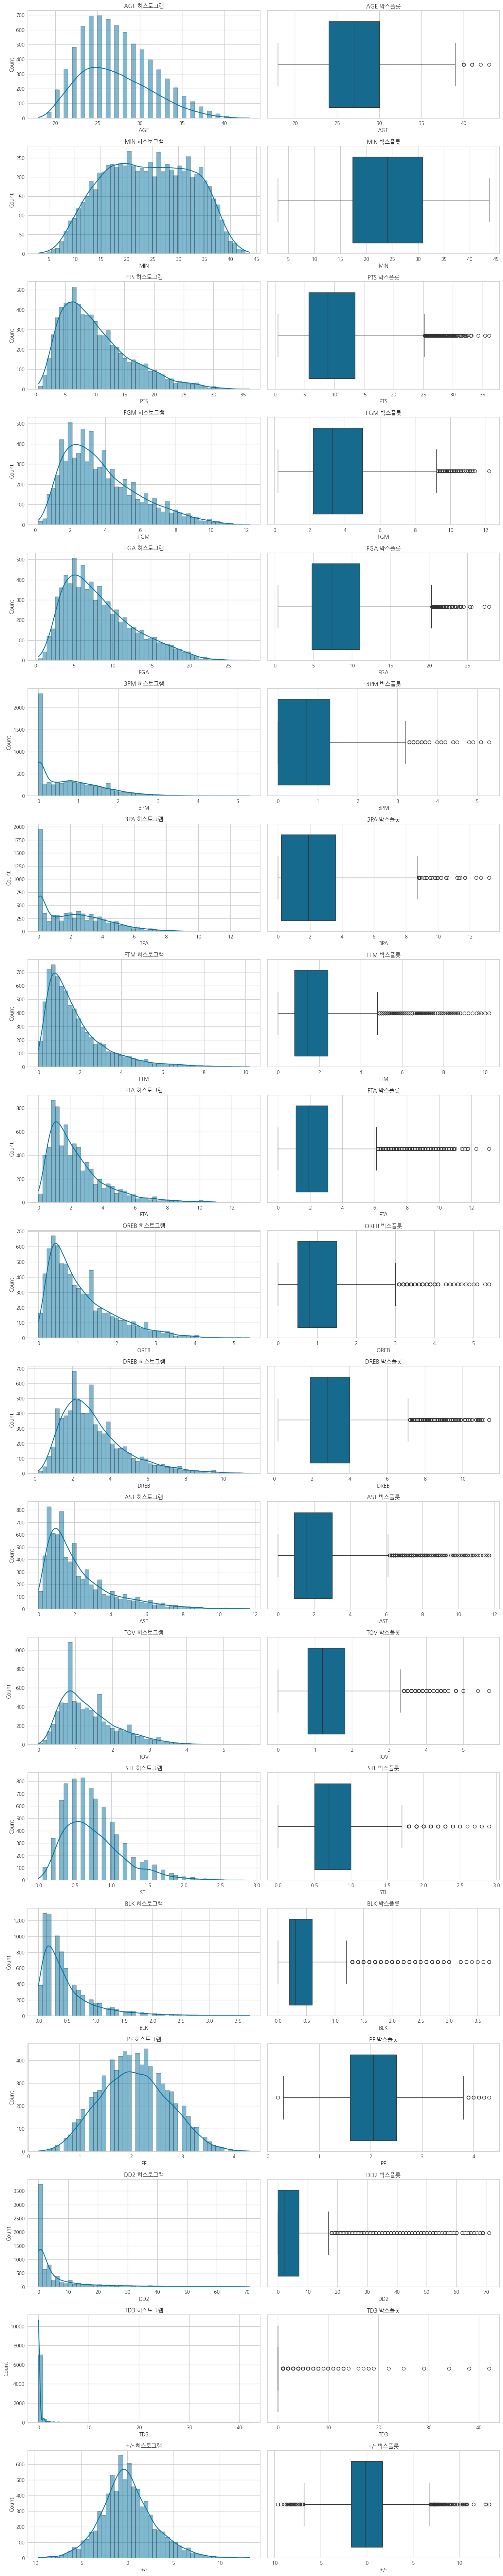

In [14]:
# 시각화함수 설정
def visualize_data(df):
    """
    주어진 데이터프레임의 수치형 변수를 이용하여 히스토그램과 박스플롯을 시각화하는 함수.

    Parameters:
    - df (pd.DataFrame): 시각화할 데이터프레임

    Returns:
    - None: 시각화를 수행하고, 플롯을 출력합니다.
    """
    # 데이터프레임에서 수치형 변수 추출
    numeric_vars = df.select_dtypes(include='number').columns.tolist()

    if not numeric_vars:
        print("수치형 변수가 없습니다.")
        return

    # 변수 개수에 맞게 서브플롯 생성
    fig, axes = plt.subplots(len(numeric_vars), 2, figsize=(15, len(numeric_vars) * 4))

    # 수치형 변수마다 시각화
    for i, var in enumerate(numeric_vars):
        # 히스토그램
        sns.histplot(df[var], bins=50, kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'{var} 히스토그램')

        # 박스플롯
        sns.boxplot(x=df[var], ax=axes[i, 1])
        axes[i, 1].set_title(f'{var} 박스플롯')

    plt.tight_layout()
    plt.show()


# 시각화 함수 사용
visualize_data(all_data)

In [15]:
'''
# 극단값 제거 함수
def remove_outliers(df, column):

    # 1사분위수(25%)와 3사분위수(75%) 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    # IQR 계산
    IQR = Q3 - Q1
    # 하한선과 상한선 계산 (IQR의 1.5배를 기준으로 설정)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # 하한선과 상한선 밖의 값 제거
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

variables = all_data.select_dtypes(include='number').columns.tolist()

# 각 변수별로 극단치를 제거
for var in variables:
    final = remove_outliers(all_data, var)

# 시각화 함수 사용
visualize_data(all_data)
'''

"\n# 극단값 제거 함수\ndef remove_outliers(df, column):\n\n    # 1사분위수(25%)와 3사분위수(75%) 계산\n    Q1 = df[column].quantile(0.25)\n    Q3 = df[column].quantile(0.75)\n    # IQR 계산\n    IQR = Q3 - Q1\n    # 하한선과 상한선 계산 (IQR의 1.5배를 기준으로 설정)\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n    # 하한선과 상한선 밖의 값 제거\n    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]\n    return df_filtered\n\nvariables = all_data.select_dtypes(include='number').columns.tolist()\n\n# 각 변수별로 극단치를 제거\nfor var in variables:\n    final = remove_outliers(all_data, var)\n\n# 시각화 함수 사용\nvisualize_data(all_data)\n"

# 3. 데이터 전처리 - (1) 변수변환, 스케일링
- 데이터의 왜곡(Skewness)을 줄이고 분포를 정규 분포에 가깝게 만들기 위해 'Yeo-Johnson' 변환 수행
    - boxcox와 유사한 변환이지만, 양수와 0, 음수 데이터 모두 적용 가능.
    - boxcox는 양수 데이터에만 적용 가능. (변환 공식에 로그 변환이 포함되기 때문)
- 변수 변환 후에도 분포의 비대칭성과 왜도가 여전히 남아있는 변수에 대해:
    - 큰 이상치의 영향이 클러스터링에 반영되어 선수 군집이 만들어지기를 원하므로 추가적인 변수 변환을 수행하지 않음.
        - 즉, 이상치 데이터가 특이점을 가진 선수를 뽑기 위해 필요하다고 판단하고 이상치를 아예 없애려고 하지 않음. 겉ㅇ
    - 분포의 정규성이 PCA와 클러스터링 진행시 큰 문제가 없을 것이라고 판단.
    - 다만 PCA와 클러스터링은 데이터의 스케일에 영향을 크게 받으므로 이후 스케일링 진행.
- 피처 스케일링
    - StandardScaling, MinMaxScaling, RobustScaling 중 **이상치(outliers)**가 존재하는 데이터에 적합한 RobustScaling 진행.



> StandardScaling: 각 피처의 평균을 0, 표준편차를 1로 맞춤

> MinMaxScaling: 모든 피처를 0과 1 사이의 값으로 변환

> RobustScaling: 중앙값(median)과 사분위수(IQR)를 사용하여 스케일링

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

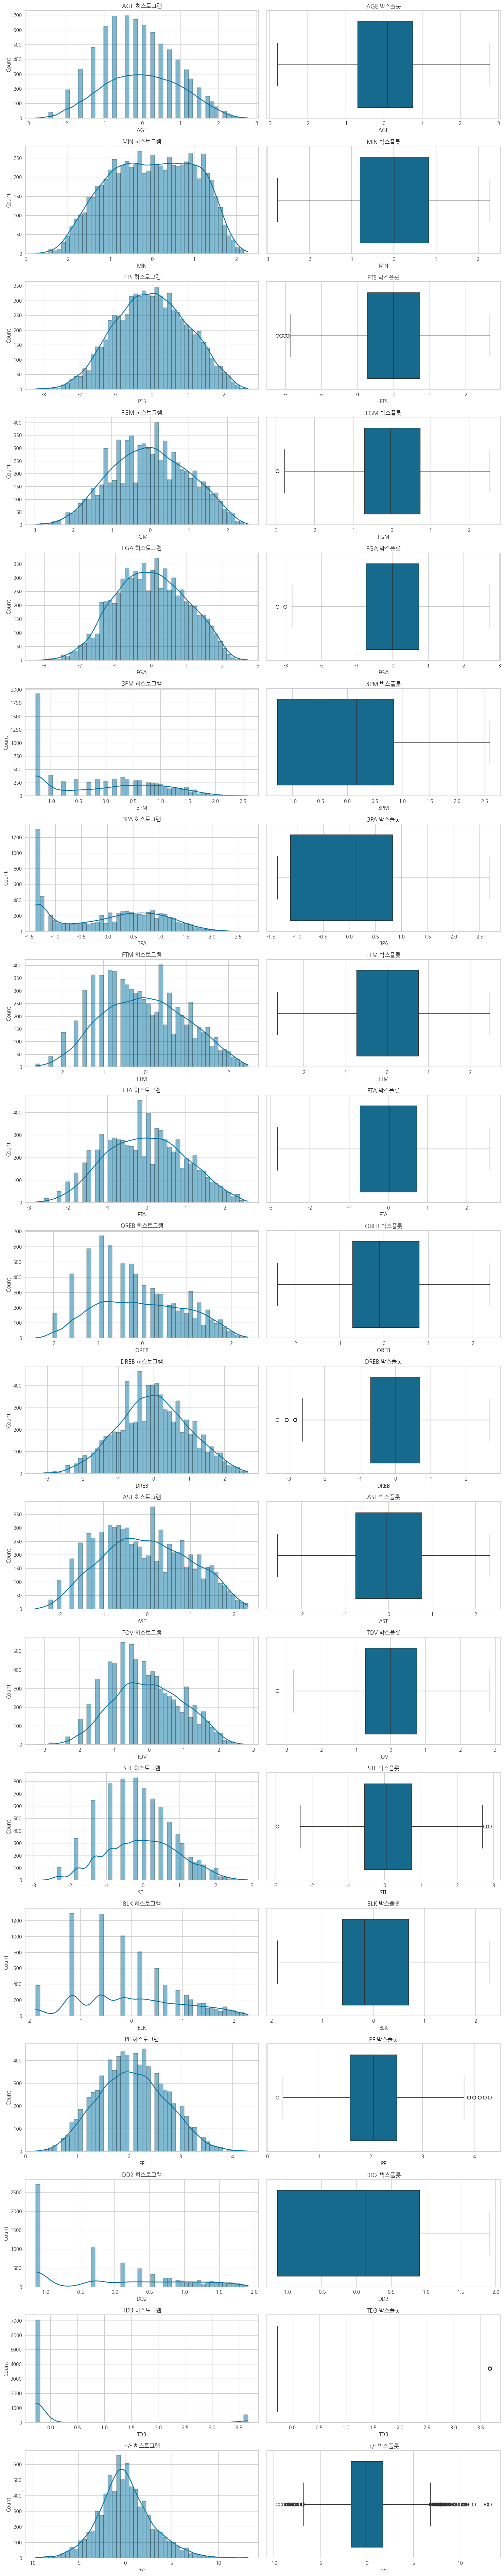

In [16]:
from sklearn.preprocessing import PowerTransformer
import pandas as pd

# Yeo-Johnson 변환 함수
def yeo_johnson_transform(df, column):
    # PowerTransformer를 사용해 Yeo-Johnson 변환 적용
    pt = PowerTransformer(method='yeo-johnson')
    df[column] = pt.fit_transform(df[[column]])

# 데이터의 수치형 변수 리스트 가져오기
variables = all_data.select_dtypes(include='number').columns.tolist()
variables.remove('PF')
variables.remove('+/-')

# 각 변수에 Yeo-Johnson 변환 적용
for var in variables:
    yeo_johnson_transform(all_data, var)

# 시각화 함수 사용
visualize_data(all_data)

In [17]:
# 피처 표준화
scaler = RobustScaler()
all_data_scaled = scaler.fit_transform(all_data.select_dtypes(include=['float64', 'int64']))

# 3. 데이터 전처리 - (2) 다중공선성 해결 - PCA
- 상관관계표 확인 시 상관계수가 높은 변수들이 꽤 보임 -> 해결하기 위해 PCA 진행 결정
- PCA: 분산의 95%를 설명하는 주성분 유지 -> 총 9개 주성분
- 주성분 로딩값 확인
    - 절댓값이 0.3이상 나온 로딩값에 대한 변수이름을 넣어서 주성분 이름 변경
    - (-)값의 경우 lower case로, (+)값의 경우 upper case로 작성
    - 이후 클러스터링 결과 해석의 용이성을 위한 것.

In [18]:
# 상관관계표
all_data.corr(numeric_only=True)

,AGE,MIN,PTS,FGM,FGA,3PM,3PA,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,PF,DD2,TD3,+/-
AGE,1.000000,0.036776,-0.036188,-0.042591,-0.036922,0.046548,0.029070,-0.067892,-0.093675,-0.086347,0.015775,0.089544,-0.042371,0.006956,-0.079551,-0.049677,-0.046431,0.001437,0.217164
MIN,0.036776,1.000000,0.900336,0.896377,0.898098,0.423551,0.427302,0.785585,0.769810,0.316641,0.694723,0.706914,0.811889,0.741089,0.288340,0.559251,0.622516,0.307133,0.237289
PTS,-0.036188,0.900336,1.000000,0.989768,0.981535,0.492016,0.496089,0.876711,0.846100,0.262384,0.645793,0.675615,0.822492,0.649825,0.245154,0.471597,0.603528,0.311893,0.246852
FGM,-0.042591,0.896377,0.989768,1.000000,0.977418,0.419080,0.423399,0.845465,0.824926,0.320708,0.674800,0.653374,0.819744,0.636495,0.290863,0.493826,0.635654,0.309919,0.236553
FGA,-0.036922,0.898098,0.981535,0.977418,1.000000,0.522341,0.535356,0.824497,0.788742,0.200659,0.597782,0.705315,0.824175,0.666464,0.187533,0.436161,0.562008,0.310157,0.196876
3PM,0.046548,0.423551,0.492016,0.419080,0.522341,1.000000,0.990926,0.229678,0.140440,-0.447915,0.015428,0.501059,0.278483,0.394068,-0.292635,-0.093019,-0.078483,0.136429,0.165346
3PA,0.029070,0.427302,0.496089,0.423399,0.535356,0.990926,1.000000,0.241233,0.152288,-0.455644,0.010457,0.525388,0.297513,0.417507,-0.300825,-0.100253,-0.075252,0.152308,0.143579
FTM,-0.067892,0.785585,0.876711,0.845465,0.824497,0.229678,0.241233,1.000000,0.982127,0.359485,0.604925,0.566254,0.802430,0.565934,0.280228,0.506001,0.618396,0.289661,0.197290
FTA,-0.093675,0.769810,0.846100,0.824926,0.788742,0.140440,0.152288,0.982127,1.000000,0.446969,0.647341,0.517513,0.798817,0.551422,0.356626,0.547902,0.656124,0.292624,0.188619
OREB,-0.086347,0.316641,0.262384,0.320708,0.200659,-0.447915,-0.455644,0.359485,0.446969,1.000000,0.727424,-0.143352,0.258909,0.116895,0.724373,0.609040,0.660105,0.108267,0.082151


In [19]:
'''# 데이터의 상관계수를 계산하고, 결과를 소수점 두 자리로 반올림
correlation_matrix = all_data.corr(numeric_only=True).round(2)

# 결과 출력
correlation_matrix'''

'# 데이터의 상관계수를 계산하고, 결과를 소수점 두 자리로 반올림\ncorrelation_matrix = all_data.corr(numeric_only=True).round(2)\n\n# 결과 출력\ncorrelation_matrix'

In [20]:
# 상관계수가 0.7 이상인 변수 쌍만을 필터링하여 보여주기

# all_data에 대해 상관계수 행렬을 계산
correlation_matrix = all_data.corr(numeric_only=True)

# 상관계수가 0.7 이상인 쌍만 필터링
# 상관계수 1인 자기 자신을 제외하기 위해 대각선을 0으로 설정
filtered_corr = correlation_matrix[correlation_matrix > 0.7]
filtered_corr = filtered_corr[filtered_corr != 1]

# 결과 출력
temp = filtered_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)
temp

,MIN,PTS,FGM,FGA,3PM,3PA,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,DD2
MIN,NaN,0.900336,0.896377,0.898098,NaN,NaN,0.785585,0.769810,NaN,NaN,0.706914,0.811889,0.741089,NaN,NaN
PTS,0.900336,NaN,0.989768,0.981535,NaN,NaN,0.876711,0.846100,NaN,NaN,NaN,0.822492,NaN,NaN,NaN
FGM,0.896377,0.989768,NaN,0.977418,NaN,NaN,0.845465,0.824926,NaN,NaN,NaN,0.819744,NaN,NaN,NaN
FGA,0.898098,0.981535,0.977418,NaN,NaN,NaN,0.824497,0.788742,NaN,NaN,0.705315,0.824175,NaN,NaN,NaN
3PM,NaN,NaN,NaN,NaN,NaN,0.990926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3PA,NaN,NaN,NaN,NaN,0.990926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FTM,0.785585,0.876711,0.845465,0.824497,NaN,NaN,NaN,0.982127,NaN,NaN,NaN,0.802430,NaN,NaN,NaN
FTA,0.769810,0.846100,0.824926,0.788742,NaN,NaN,0.982127,NaN,NaN,NaN,NaN,0.798817,NaN,NaN,NaN
OREB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.727424,NaN,NaN,NaN,0.724373,NaN
DREB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.727424,NaN,NaN,NaN,NaN,NaN,0.798079


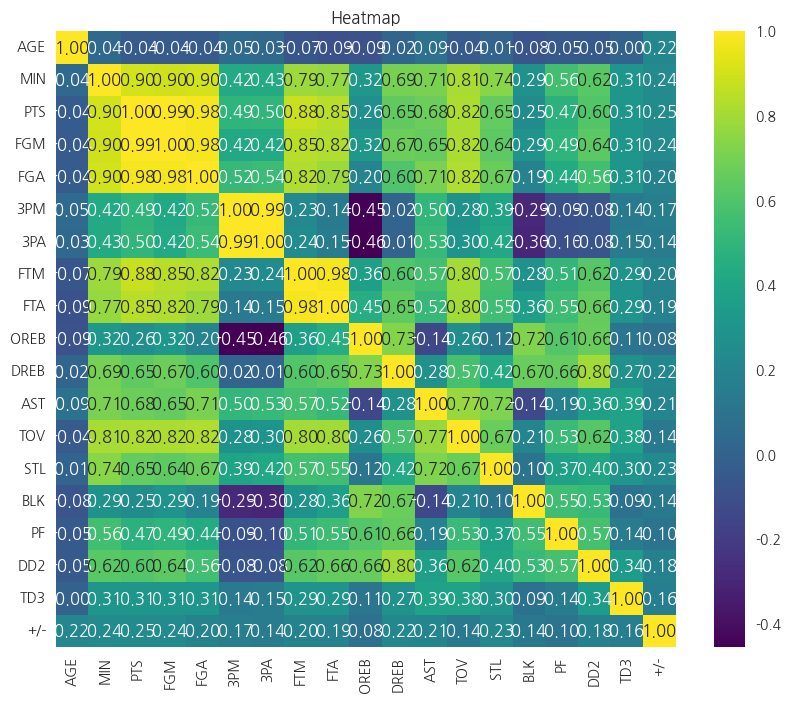

In [21]:
# 히트맵으로 상관관계 확인
def plot_heatmap(dataframe, title='Heatmap', cmap='viridis'):
    """
    이 함수는 주어진 데이터프레임에서 히트맵을 생성합니다.

    Args:
    dataframe (pd.DataFrame): 히트맵을 생성할 데이터프레임.
    title (str): 히트맵의 제목.
    cmap (str): 사용할 컬러맵.

    Returns:
    Matplotlib figure: 히트맵이 포함된 그림을 출력합니다.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(dataframe.corr(numeric_only=True), annot=True, fmt=".2f", cmap=cmap)
    plt.title(title)
    plt.show()


# 히트맵함수 적용
plot_heatmap(all_data, 'Heatmap')

In [22]:
# PCA 적용
pca = PCA(n_components=0.95)  # 분산의 95%를 설명하는 주성분 유지
all_data_pca = pca.fit_transform(all_data_scaled)

# 주성분 데이터프레임 생성
pca_columns = [f'PC{i+1}' for i in range(all_data_pca.shape[1])]
all_data_pca_df = pd.DataFrame(data=all_data_pca, columns=pca_columns)

# 설명된 분산 비율 확인
explained_variance = pca.explained_variance_ratio_
print(f"각 주성분의 설명된 분산 비율: {explained_variance}")
print(f"총 설명된 분산: {sum(explained_variance):.2f}")

각 주성분의 설명된 분산 비율: [0.46802759 0.15738901 0.09376556 0.07917878 0.04605822 0.03551772
 0.03374999 0.02259891 0.01714457]
총 설명된 분산: 0.95


In [23]:
# 주성분 로딩 확인
pca_components = pd.DataFrame(pca.components_, columns=all_data.select_dtypes(include=['float64', 'int64']).columns)
pca_components_tr = pca_components.T
print(pca_components_tr)

             0         1         2         3         4         5         6  \
AGE  -0.008313 -0.072304  0.115745  0.434853  0.841124 -0.209245  0.103440   
MIN   0.274921 -0.053666 -0.091296  0.030935  0.076161  0.097727  0.072648   
PTS   0.311174 -0.094964 -0.130289  0.007077 -0.064445 -0.170756  0.162189   
FGM   0.314216 -0.059366 -0.122883  0.001202 -0.051982 -0.154921  0.159668   
FGA   0.297734 -0.130017 -0.138359 -0.024466 -0.032859 -0.110816  0.179938   
3PM   0.074888 -0.279360 -0.078985  0.057440 -0.079669  0.115752  0.416010   
3PA   0.083262 -0.308490 -0.084126  0.042285 -0.085470  0.133287  0.431297   
FTM   0.288200 -0.002304 -0.113383 -0.047469 -0.057856 -0.362834 -0.194065   
FTA   0.294360  0.055701 -0.098315 -0.060531 -0.064571 -0.350432 -0.232965   
OREB  0.140369  0.451103  0.050681  0.000095  0.024088 -0.018800 -0.037602   
DREB  0.268373  0.278247  0.031672  0.069073  0.076165  0.054358  0.265415   
AST   0.217930 -0.297579  0.004386 -0.015618  0.132905  0.149226

In [24]:
# 절대값 0.3 이상만 필터링
# 상관계수 1인 자기 자신을 제외하기 위해 대각선을 0으로 설정
filtered_pca_loading = pca_components_tr[(pca_components_tr >= 0.3) | (pca_components_tr <= -0.3)]
filtered_pca_loading

,0,1,2,3,4,5,6,7,8
AGE,NaN,NaN,NaN,0.434853,0.841124,NaN,NaN,NaN,NaN
MIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PTS,0.311174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FGM,0.314216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FGA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3PM,NaN,NaN,NaN,NaN,NaN,NaN,0.416010,NaN,NaN
3PA,NaN,-0.308490,NaN,NaN,NaN,NaN,0.431297,NaN,NaN
FTM,NaN,NaN,NaN,NaN,NaN,-0.362834,NaN,NaN,NaN
FTA,NaN,NaN,NaN,NaN,NaN,-0.350432,NaN,NaN,NaN
OREB,NaN,0.451103,NaN,NaN,NaN,NaN,NaN,NaN,NaN


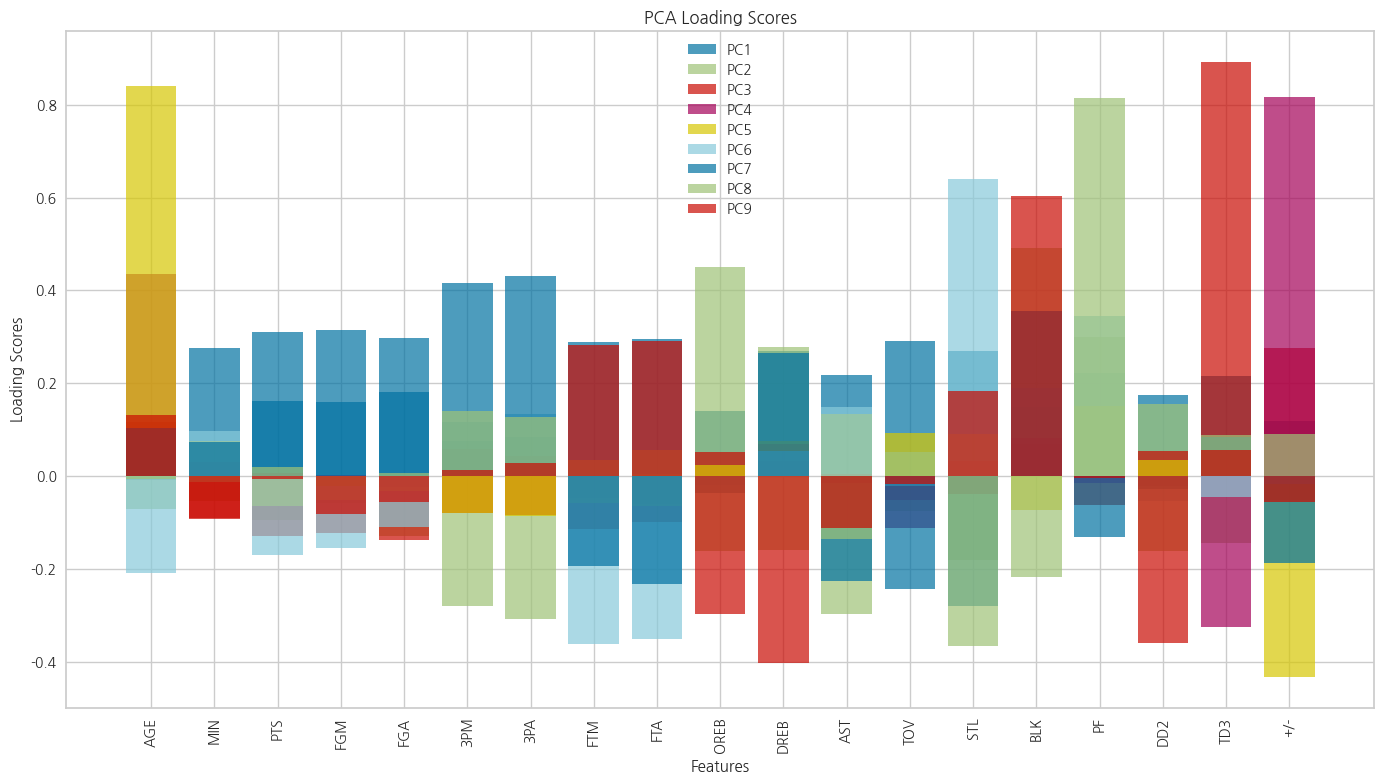

In [25]:
# 변수의 영향 시각화
plt.figure(figsize=(14, 8))
for i in range(len(pca_columns)):
    plt.bar(x=pca_components.columns, height=pca_components.iloc[i], alpha=0.7, label=f'PC{i+1}')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Loading Scores')
plt.title('PCA Loading Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# pca 적용데이터 - 열 이름 변경
all_data_pca_df = all_data_pca_df.rename(columns={'PC1': 'PTS_FGM'})
all_data_pca_df = all_data_pca_df.rename(columns={'PC2': '3pa_OREB_BLK'})
all_data_pca_df = all_data_pca_df.rename(columns={'PC3': 'TD3'})
all_data_pca_df = all_data_pca_df.rename(columns={'PC4': 'AGE_td3_(+)'})
all_data_pca_df = all_data_pca_df.rename(columns={'PC5': 'AGE_(-)'})
all_data_pca_df = all_data_pca_df.rename(columns={'PC6': 'ftm_fta_STL_PF'})
all_data_pca_df = all_data_pca_df.rename(columns={'PC7': '3PM_3PA_BLK'})
all_data_pca_df = all_data_pca_df.rename(columns={'PC8': 'stl_PF'})
all_data_pca_df = all_data_pca_df.rename(columns={'PC9': 'dreb_BLK_dd2'})

# pca 적용데이터
all_data_pca_df

,PTS_FGM,3pa_OREB_BLK,TD3,AGE_td3_(+),AGE_(-),ftm_fta_STL_PF,3PM_3PA_BLK,stl_PF,dreb_BLK_dd2
0,4.115266,-1.542904,-1.148591,1.070733,-0.717940,-0.198820,-0.741100,-0.465834,0.513054
1,4.583963,-1.403123,2.011066,-1.647124,-0.129483,-0.889931,0.529702,-0.125175,1.044400
2,4.441385,2.171527,-0.454514,1.590874,-0.222518,-1.097187,-0.412623,0.354149,-0.009064
3,5.223238,-0.569739,2.475405,-0.469725,-1.171963,0.095561,-0.409647,0.733047,0.346648
4,3.883298,-0.002584,-0.974466,0.873772,-0.981407,0.150740,0.191595,-0.121268,0.488843
...,...,...,...,...,...,...,...,...,...
7549,-4.280371,0.074506,0.755731,0.093797,0.165946,-0.291897,0.153985,-0.146510,0.071360
7550,-3.551003,1.002176,0.715475,-0.210964,-0.609135,-0.179785,-0.380243,-0.583279,0.783812
7551,-4.686253,-0.411661,0.889510,0.353197,0.871184,0.138869,0.426384,-0.398673,-0.367361
7552,-4.882864,0.280480,0.900152,-0.044233,0.201897,-0.256295,0.033515,-0.351183,0.030451


In [27]:
# 상관관계 확인
all_data_pca_df.corr(numeric_only=True)

,PTS_FGM,3pa_OREB_BLK,TD3,AGE_td3_(+),AGE_(-),ftm_fta_STL_PF,3PM_3PA_BLK,stl_PF,dreb_BLK_dd2
PTS_FGM,1.000000e+00,3.637664e-16,1.727068e-16,-2.689259e-16,-1.848157e-16,-4.045446e-16,1.052482e-16,-2.619687e-16,1.129633e-15
3pa_OREB_BLK,3.637664e-16,1.000000e+00,-4.393176e-16,-1.206651e-16,-1.916232e-16,-3.793279e-16,4.882296e-16,-5.741527e-16,6.910740e-16
TD3,1.727068e-16,-4.393176e-16,1.000000e+00,-2.868642e-17,-5.146301e-16,-4.842113e-16,3.384530e-16,1.441375e-16,4.670415e-16
AGE_td3_(+),-2.689259e-16,-1.206651e-16,-2.868642e-17,1.000000e+00,5.577605e-16,-5.301317e-16,1.956815e-16,-2.061959e-16,8.479508e-16
AGE_(-),-1.848157e-16,-1.916232e-16,-5.146301e-16,5.577605e-16,1.000000e+00,5.696030e-16,-4.730414e-16,-3.121937e-16,-6.572744e-16
ftm_fta_STL_PF,-4.045446e-16,-3.793279e-16,-4.842113e-16,-5.301317e-16,5.696030e-16,1.000000e+00,-8.958813e-16,-1.823725e-15,1.586898e-15
3PM_3PA_BLK,1.052482e-16,4.882296e-16,3.384530e-16,1.956815e-16,-4.730414e-16,-8.958813e-16,1.000000e+00,4.086981e-16,8.178290e-16
stl_PF,-2.619687e-16,-5.741527e-16,1.441375e-16,-2.061959e-16,-3.121937e-16,-1.823725e-15,4.086981e-16,1.000000e+00,-1.183287e-15
dreb_BLK_dd2,1.129633e-15,6.910740e-16,4.670415e-16,8.479508e-16,-6.572744e-16,1.586898e-15,8.178290e-16,-1.183287e-15,1.000000e+00


In [28]:
# 상관계수가 0.7 이상인 변수 쌍만을 필터링하여 보여주기 - Good~

# all_data에 대해 상관계수 행렬을 계산
correlation_matrix = all_data_pca_df.corr(numeric_only=True)

# 상관계수가 0.7 이상인 쌍만 필터링
# 상관계수 1인 자기 자신을 제외하기 위해 대각선을 0으로 설정
filtered_corr = correlation_matrix[correlation_matrix > 0.7]
filtered_corr = filtered_corr[filtered_corr != 1]

# 결과 출력
temp = filtered_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)
temp

""


# 4. 클러스터링
- Kmeans, HAC에서 적합한 군집 개수 확인 -> k=4
- 두 기법의 장단점을 고려하였을 때, 본 프로젝트에서는 HAC 클러스터링이 더 적합할 것이라고 판단.
    - -> HAC 클러스터링 이후 시각화까지 진행. 4개 그룹이 잘 구분된 것 확인

- *실루엣 점수가 0.2~0.3 사이에 머무는 상태

In [29]:
# 이후 동일한 진행 위해 filtered_data 생성
filtered_data = all_data_pca_df.copy()

In [30]:
'''# 중복 의미를 가지는 열들을 식별하고 꼭 필요한 열들만 선택하여 새로운 데이터프레임 생성 (총 38개 선택)
selected_columns = [
    'OFF_PTS', 'OFF_FGM', 'OFF_FGA',
    'OFF_3PM', 'OFF_3PA', 'OFF_FTM', 'OFF_FTA',
    'OFF_OREB', 'OFF_DREB', 'OFF_AST', 'OFF_TOV',
    'OFF_STL', 'OFF_BLK', 'OFF_PF', 'OFF_DD2', 'OFF_TD3',
    'OFF_+/-','ADV_AGE', 'MIN_AVG'
]

# 필터링된 열만을 포함하는 새로운 데이터프레임
filtered_data = all_data[selected_columns]
filtered_data'''

"# 중복 의미를 가지는 열들을 식별하고 꼭 필요한 열들만 선택하여 새로운 데이터프레임 생성 (총 38개 선택)\nselected_columns = [\n    'OFF_PTS', 'OFF_FGM', 'OFF_FGA',\n    'OFF_3PM', 'OFF_3PA', 'OFF_FTM', 'OFF_FTA',\n    'OFF_OREB', 'OFF_DREB', 'OFF_AST', 'OFF_TOV',\n    'OFF_STL', 'OFF_BLK', 'OFF_PF', 'OFF_DD2', 'OFF_TD3',\n    'OFF_+/-','ADV_AGE', 'MIN_AVG'\n]\n\n# 필터링된 열만을 포함하는 새로운 데이터프레임\nfiltered_data = all_data[selected_columns]\nfiltered_data"

In [31]:
'''# 중복 의미를 가지는 열들을 식별하고 꼭 필요한 열들만 선택하여 새로운 데이터프레임 생성 (총 38개 선택)
selected_columns = [
    'PTS', 'FGM', 'FGA',
    '3PM', '3PA', 'FTM', 'FTA',
    'OREB', 'DREB', 'AST', 'TOV',
    'STL', 'BLK', 'PF', 'DD2', 'TD3',
    '+/-'
]

# 필터링된 열만을 포함하는 새로운 데이터프레임
filtered_data = all_data[selected_columns]
filtered_data'''

"# 중복 의미를 가지는 열들을 식별하고 꼭 필요한 열들만 선택하여 새로운 데이터프레임 생성 (총 38개 선택)\nselected_columns = [\n    'PTS', 'FGM', 'FGA',\n    '3PM', '3PA', 'FTM', 'FTA',\n    'OREB', 'DREB', 'AST', 'TOV',\n    'STL', 'BLK', 'PF', 'DD2', 'TD3',\n    '+/-'\n]\n\n# 필터링된 열만을 포함하는 새로운 데이터프레임\nfiltered_data = all_data[selected_columns]\nfiltered_data"

In [32]:
# 군집화 결과 데이터프레임에 추가
fd_hac = filtered_data.copy()

In [33]:
'''# 표준화
scaler = MinMaxScaler()
#scaler = RobustScaler()
filtered_data = scaler.fit_transform(filtered_data)
filtered_data'''

'# 표준화\nscaler = MinMaxScaler()\n#scaler = RobustScaler()\nfiltered_data = scaler.fit_transform(filtered_data)\nfiltered_data'

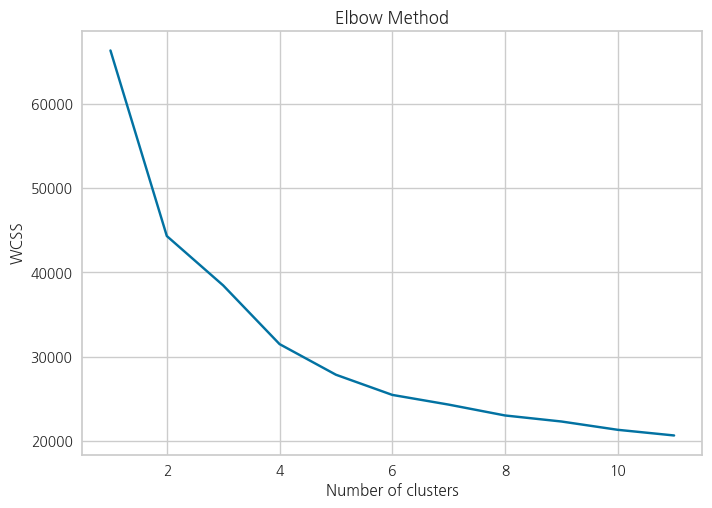

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 엘보우 기법을 위한 왜곡(WCSS) 계산
wcss = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters=i, random_state=42, max_iter=500)
    kmeans.fit(filtered_data)
    wcss.append(kmeans.inertia_)

# WCSS 값을 이용해 그래프 시각화
plt.plot(range(1, 12), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


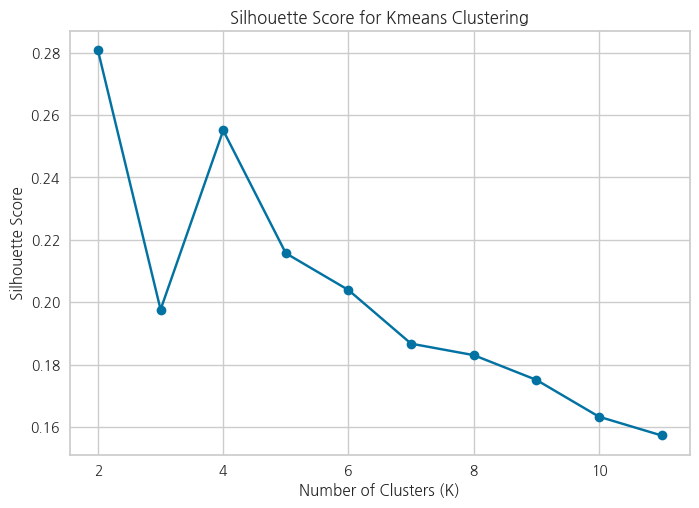

In [35]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_values = range(2, 12)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=500)
    labels = kmeans.fit_predict(filtered_data)
    score = silhouette_score(filtered_data, labels)
    silhouette_scores.append(score)

# K 값에 따른 실루엣 점수 시각화
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Kmeans Clustering')
plt.show()

In [36]:
#filtered_data.drop(columns="Cluster")
score_dict_ward = {}
for i in range(2,15):
    clusterer = AgglomerativeClustering(n_clusters=i, linkage='ward')
    data_ = filtered_data
    y_predict = clusterer.fit_predict(data_)
    cluster_labels = clusterer.labels_
    score_ = silhouette_score(data_, cluster_labels)
    score_dict_ward[i] = score_
score_dict_ward

{2: 0.2175582997582081,
 3: 0.23670966441467203,
 4: 0.20300812504213808,
 5: 0.1580192031086106,
 6: 0.15159041906077075,
 7: 0.12924809060030426,
 8: 0.11251102278005187,
 9: 0.11332684886313374,
 10: 0.11035769812568673,
 11: 0.09791459931839895,
 12: 0.088322128379076,
 13: 0.08605197227803806,
 14: 0.08473991881308154}

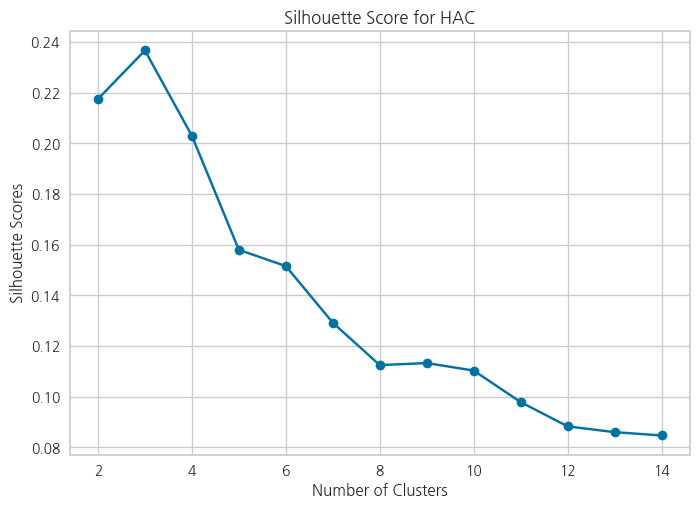

<Figure size 800x550 with 0 Axes>

In [37]:
x_value = range(2,15)
y_value = [score_dict_ward[i] for i in x_value]
x = x_value
y = y_value
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Scores")
plt.title('Silhouette Score for HAC')
plt.plot(x,y,marker='o')
plt.show()
plt.savefig('silhouette_score_Hierarchical_PCA.png')

In [38]:
# HAC 군집화 수행
hac = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')  #군집 내 분산 최소화
# kmeans
#kmeans = KMeans(n_clusters=4, random_state=42, max_iter=500)

labels = hac.fit_predict(filtered_data)

# 군집화 결과 데이터프레임에 추가
#fd_hac = filtered_data.copy()
fd_hac['Cluster'] = labels

In [39]:
fd_hac

,PTS_FGM,3pa_OREB_BLK,TD3,AGE_td3_(+),AGE_(-),ftm_fta_STL_PF,3PM_3PA_BLK,stl_PF,dreb_BLK_dd2,Cluster
0,4.115266,-1.542904,-1.148591,1.070733,-0.717940,-0.198820,-0.741100,-0.465834,0.513054,1
1,4.583963,-1.403123,2.011066,-1.647124,-0.129483,-0.889931,0.529702,-0.125175,1.044400,2
2,4.441385,2.171527,-0.454514,1.590874,-0.222518,-1.097187,-0.412623,0.354149,-0.009064,1
3,5.223238,-0.569739,2.475405,-0.469725,-1.171963,0.095561,-0.409647,0.733047,0.346648,2
4,3.883298,-0.002584,-0.974466,0.873772,-0.981407,0.150740,0.191595,-0.121268,0.488843,1
...,...,...,...,...,...,...,...,...,...,...
7549,-4.280371,0.074506,0.755731,0.093797,0.165946,-0.291897,0.153985,-0.146510,0.071360,0
7550,-3.551003,1.002176,0.715475,-0.210964,-0.609135,-0.179785,-0.380243,-0.583279,0.783812,0
7551,-4.686253,-0.411661,0.889510,0.353197,0.871184,0.138869,0.426384,-0.398673,-0.367361,0
7552,-4.882864,0.280480,0.900152,-0.044233,0.201897,-0.256295,0.033515,-0.351183,0.030451,0


In [40]:
fd_hac['Cluster'].value_counts()

,count
Cluster,
0,3057
1,2761
3,1214
2,522


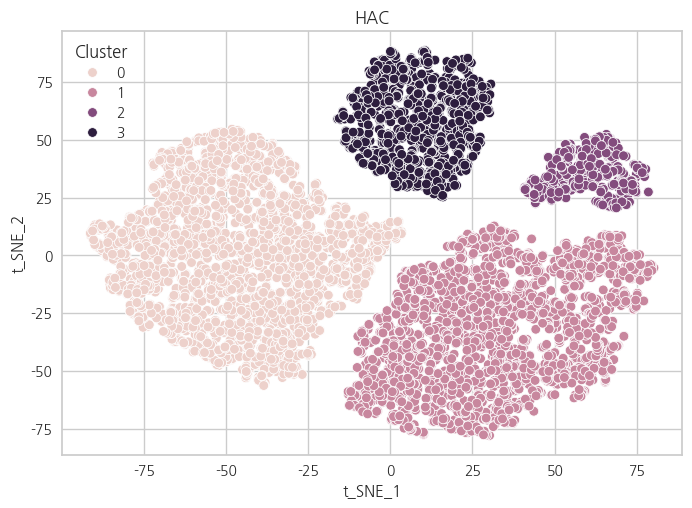

In [41]:
tsne = TSNE(n_components=2, perplexity=20)
data_2d = tsne.fit_transform(fd_hac)
df_data_2d = pd.DataFrame(data=data_2d, columns=["t_SNE_1", "t_SNE_2"])
df_data_2d["Cluster"] = fd_hac['Cluster']
#df_data_2d
sns_plot = sns.scatterplot(x="t_SNE_1", y="t_SNE_2", hue="Cluster", data=df_data_2d)
plt.title('HAC')   # 제목설정
plt.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


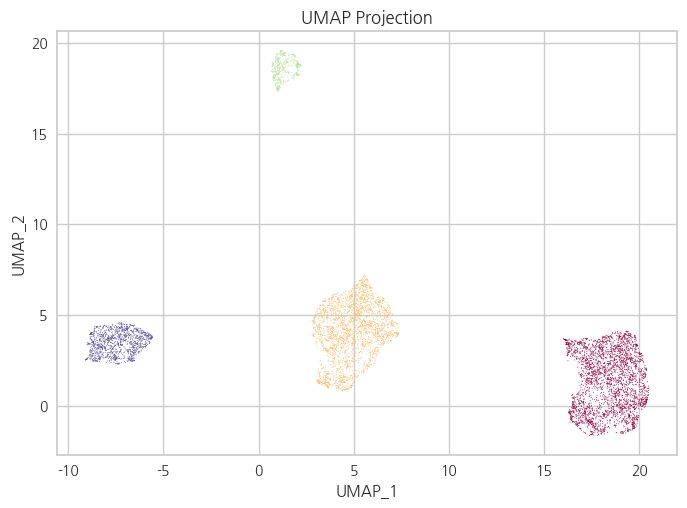

In [42]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(fd_hac)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c= fd_hac['Cluster'], s=0.1, cmap='Spectral')
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")
plt.title("UMAP Projection")
plt.legend()
plt.show()

In [43]:
t0=fd_hac[fd_hac['Cluster'] == 0]
t0.describe()

,PTS_FGM,3pa_OREB_BLK,TD3,AGE_td3_(+),AGE_(-),ftm_fta_STL_PF,3PM_3PA_BLK,stl_PF,dreb_BLK_dd2,Cluster
count,3057.000000,3057.000000,3057.000000,3057.000000,3057.000000,3057.000000,3057.000000,3057.000000,3057.000000,3057.0
mean,-1.855172,-0.273364,0.080123,-0.036793,-0.043697,0.014856,0.052052,-0.009391,0.006527,0.0
std,1.201905,0.937942,0.412752,0.643667,0.662256,0.550966,0.575338,0.402212,0.380670,0.0
min,-5.545266,-2.316649,-1.417606,-2.605107,-1.843756,-1.822087,-1.800804,-1.564782,-1.395714,0.0
25%,-2.722309,-1.019880,-0.214154,-0.447634,-0.541448,-0.354347,-0.350249,-0.279691,-0.249738,0.0
50%,-1.793097,-0.385901,0.090757,-0.039039,-0.071227,-0.015792,0.055164,-0.009786,-0.000171,0.0
75%,-0.964856,0.372879,0.375793,0.383988,0.434470,0.375101,0.451345,0.258540,0.268261,0.0
max,1.293988,2.579026,1.251944,2.242409,1.858537,2.484641,1.939174,1.653684,1.250457,0.0


In [44]:
t1=fd_hac[fd_hac['Cluster'] == 1]
t1.describe()

,PTS_FGM,3pa_OREB_BLK,TD3,AGE_td3_(+),AGE_(-),ftm_fta_STL_PF,3PM_3PA_BLK,stl_PF,dreb_BLK_dd2,Cluster
count,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.000000,2761.0
mean,1.461019,-0.278438,-0.614771,0.225344,-0.002363,0.036917,-0.011055,-0.013349,0.010278,1.0
std,1.133509,1.093448,0.431888,0.955947,0.630011,0.598955,0.585721,0.489707,0.409704,0.0
min,-1.963833,-2.351982,-2.033445,-2.894059,-1.839686,-1.685123,-1.934664,-1.665934,-1.592028,1.0
25%,0.598694,-1.119721,-0.894777,-0.418350,-0.452355,-0.365844,-0.403770,-0.336926,-0.257594,1.0
50%,1.449376,-0.501498,-0.612897,0.243892,-0.005332,0.024423,-0.012970,-0.017732,0.017471,1.0
75%,2.270184,0.355009,-0.327374,0.882802,0.433835,0.440105,0.399352,0.322813,0.290043,1.0
max,4.500245,2.950019,0.762113,3.202667,2.074872,2.065907,1.870361,1.663519,1.222195,1.0


In [45]:
t2=fd_hac[fd_hac['Cluster'] == 2]
t2.describe()

,PTS_FGM,3pa_OREB_BLK,TD3,AGE_td3_(+),AGE_(-),ftm_fta_STL_PF,3PM_3PA_BLK,stl_PF,dreb_BLK_dd2,Cluster
count,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.0
mean,3.398516,-0.764478,2.829482,-0.871384,0.000018,-0.053282,0.097056,0.066819,0.032377,2.0
std,1.295746,1.021285,0.431776,1.018489,0.678447,0.598660,0.561696,0.490339,0.409746,0.0
min,-1.904573,-2.636313,1.587448,-3.793641,-1.809398,-1.787914,-1.686029,-1.224544,-1.352678,2.0
25%,2.637561,-1.480592,2.515716,-1.547185,-0.464467,-0.452598,-0.243487,-0.245864,-0.240700,2.0
50%,3.573895,-1.031418,2.817022,-0.859769,-0.027940,-0.086308,0.099080,0.091652,0.033206,2.0
75%,4.320473,-0.093121,3.110996,-0.148875,0.445798,0.347441,0.473463,0.387922,0.328976,2.0
max,5.915836,2.313672,4.035532,1.944756,2.004992,1.927381,2.176482,1.447463,1.044400,2.0


In [46]:
t3=fd_hac[fd_hac['Cluster'] == 3]
t3.describe()

,PTS_FGM,3pa_OREB_BLK,TD3,AGE_td3_(+),AGE_(-),ftm_fta_STL_PF,3PM_3PA_BLK,stl_PF,dreb_BLK_dd2,Cluster
count,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.0
mean,-0.112553,1.650329,-0.020216,-0.045168,0.115401,-0.098460,-0.147665,0.025274,-0.053734,3.0
std,1.031172,0.553593,0.354835,0.726694,0.647777,0.537567,0.392500,0.487229,0.401507,0.0
min,-2.315760,0.013277,-1.463616,-2.871827,-1.666091,-1.668836,-1.361695,-1.596289,-1.374618,3.0
25%,-0.917259,1.300637,-0.249684,-0.516153,-0.364988,-0.484019,-0.400833,-0.313269,-0.304924,3.0
50%,-0.163398,1.681864,-0.019826,-0.043414,0.116190,-0.119481,-0.122765,0.015628,-0.043705,3.0
75%,0.691815,2.032589,0.211194,0.431766,0.534989,0.276420,0.130811,0.362866,0.204512,3.0
max,2.731678,3.001945,1.359918,2.664685,2.696194,1.933957,1.381197,2.561171,1.258084,3.0


In [47]:
#t4=fd_hac[fd_hac['Cluster'] == 4]
#t4.describe()

In [48]:
#t0.to_csv('cluster0.csv')
#t1.to_csv('cluster1.csv')
#t2.to_csv('cluster2.csv')
#t3.to_csv('cluster3.csv')
#t4.to_csv('cluster4.csv')

In [49]:
#fd_hac.to_csv('fd_hac.csv')